# Circuito Display 7 segmentos usando programación genética

Usamos como base la libreria deap, que nos ayuda a correr el algoritmo de programación genetica, algunas otras dependencias para mostrar los resultados

In [1]:
from deap import algorithms,base,creator, tools, gp
import numpy as np
import operator as op
import random
import networkx as nx
import pygraphviz as pgv
import matplotlib.pyplot as plt

# Datos



Definimos las entradas y salidas tradicionales de un display de 7 segmentos (e.g el 0 se representa con todos los pines menos los del medio, es decir que para la entrada `[0,0,0]` debemos obtener `[1,1,1,1,1,1,0]`)

In [2]:
data = np.array(
   [  #-INPUT-##-------OUTPUT------#
      [0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
      [0, 0, 1, 0, 1, 1, 0, 0, 0, 0],
      [0, 1, 0, 1, 1, 0, 1, 1, 1, 0],
      [0, 1, 1, 1, 1, 1, 1, 0, 0, 1],
      [1, 0, 0, 0, 1, 1, 0, 0, 1, 1],
      [1, 0, 1, 1, 0, 1, 1, 0, 1, 1],
      [1, 1, 0, 1, 0, 1, 1, 1, 1, 1],
      [1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
   ]
).astype(np.bool_)

# inputs = list(map(tuple,data[:,:3].tolist()))
# outputs = list(map(tuple,(data[:,3:].tolist())))
inputs = data[:,:3]
outputs = data[:,3:]

# Estructura de un programa

Definimos los operadores logico AND, OR y NOT, ademas de los literales True (1) y False (0). Que son los compoenentes fundamentales que construyen la "gramatica" de nuestras expresiones booleanas que se pueden construir como circuitos

In [3]:
pset = gp.PrimitiveSet("main",3,"IN")
pset.addPrimitive(np.logical_and,2,name="vand")
pset.addPrimitive(np.logical_or,2,name="vor")
pset.addPrimitive(np.logical_not,1,name="vnot")
pset.addTerminal(True,name="1")
pset.addTerminal(False, name="0")

Con los operadores y literales que definimos podemos crear una expresion (`"expr"`), que podemos usar como base para generar nuestros indibiduos, que terminan siendo expresiones. Nuestra poblacion es un grupo (lista en este caso) de individuos

In [5]:
# Instanciamos un toolbox, para agregar los generadores de individuos y poblaciones que usa deap
toolbox = base.Toolbox()
# Agregamos el generador de expresiones con pset que tiene los operadores y terminales
toolbox.register("expr", gp.genFull, pset=pset, min_=2, max_=4)
# Agregamos el generador de individuos y poblaciones

# Tenemos un evaluador de fitness que hace parte del individuo el individuo
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
# La base del individuo esun arbol 
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)
# Que vamos a llenar de con el generador de expresiones
toolbox.register("individual", tools.initIterate, creator.Individual,toolbox.expr)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)
# Nos permite "compilar" la expresion, esto lo require deap para poder ejecutarla
toolbox.register("compile", gp.compile, pset=pset)

Ahora definimos como se evalua nuestro individuo, es decir le pasamos los inputs y los comparamos con los outputs, entre mas tenga exactamente correctos mejor

In [8]:
def eval(individual,*,i):
   func = toolbox.compile(expr=individual)
   results = func(*inputs.T) == outputs[:,i]
   return (results.sum(),)

# Estrategias de evolución

Vamos a usar 
- Cruce basado en un punto aleatorio y mezcla de los componentes respectivos de cada padre
- Selección utilizando el método de torneo
- Mutación uniforme, en un punto seleccionado al azar

In [9]:
# Estrategia de cruce
toolbox.register("mate", gp.cxOnePoint)
# Estrategia de seleccion
toolbox.register("select",tools.selTournament,tournsize=3)
# Estrategia de mutacion

# EL mutador necesita un generador de expresiones que genere el nuevo valor a poner en el nodo
# seleccionado
toolbox.register("expr_mut", gp.genGrow, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# Parametros

Consideramos probabilidad de cruce, probabilidad de mutación, tamaño de población y número de generaciones

In [14]:
mate_prob = 0.5
mut_prob = 0.2
pop_size = 300
generations = 100

# Loops de evolucion

Se genera un circuito para cada unos de los 7 pines del display

In [33]:
random.seed(21) # Para tener resultados reproducibles
bests = [] # para guardar el mejor de cada pin

for i in range(7):

   # Ejecutamos el algoritmo genetico
   # lo repetimos hasta conseguir un individuo que tenga
   # el fitness que queremos (8)

   while True:
      # Poblacion inicial
      pop = toolbox.population(n=pop_size)
      # Para guardar al mejor
      hof = tools.HallOfFame(1)

      # Si ya se habia registrado un evaluador, lo quitamos
      if hasattr(toolbox, "evaluate"):
         toolbox.unregister("evaluate")
      # Y registramos uno nuevo, que evalue para 
      # entradas y salidas del pin i
      toolbox.register("evaluate", eval, i=i)

      pop, logbook = algorithms.eaSimple(
         population=pop,
         toolbox=toolbox,
         cxpb=mate_prob,
         mutpb=mut_prob,
         ngen=1,
         halloffame=hof,
         verbose=False,
      )
      if hof[0].fitness.values[0] == 8:
         bests.append(hof[0])
         break

# Visualización


Creamos una función para graficar cada circuito como grafo, nos apoyamos en la libreria nx que tiene integración con deap

In [47]:
# Estilos nodos
ref_colors = {
   "vor": "royalblue",
   "vand": "mediumvioletred",
   "vnot": "darkolivegreen",
   "IN0": "dimgray",
   "IN1": "dimgray",
   "IN2": "dimgray",
   "0": "black",
   False: "black",
   "1": "lavender",
   True: "lavender"
}

def graph(result,i):
   fitness = result.fitness.values[0]
   nodes, edges, labels = gp.graph(result)
   g = nx.Graph()
   g.add_nodes_from(nodes)
   g.add_edges_from(edges)
   pos = nx.nx_agraph.graphviz_layout(g, prog="dot")

   node_colors = [ref_colors[labels[n]] for n in nodes]
   nx.draw_networkx_nodes(g, pos, node_size=1000, node_shape="H", node_color=node_colors)
   nx.draw_networkx_edges(g, pos)
   nx.draw_networkx_labels(g, pos, labels, font_color='white')
   plt.title(f"Circuito para pin {i}, fitness {fitness}")
   plt.show()

En el grafo se representan las entradas como IN1,IN2,IN3,etc. respectivamente, ademas como 0 y 1 que representan constantes (un input vcc y un input "muerto")

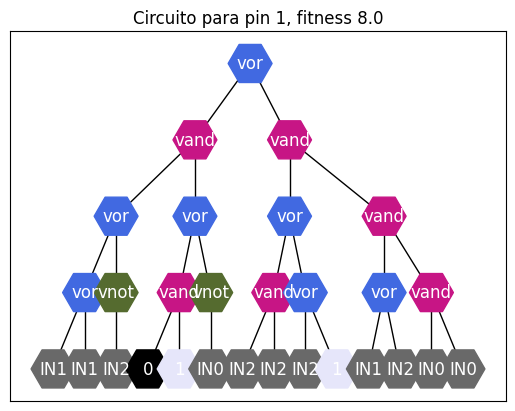

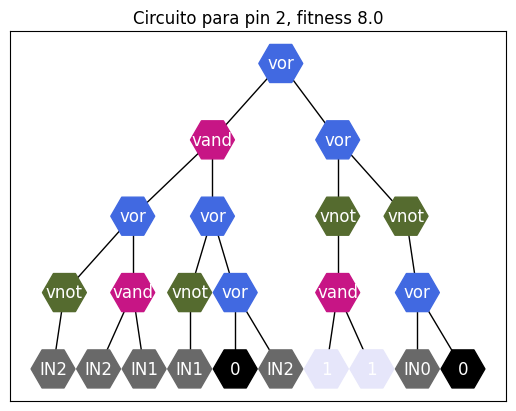

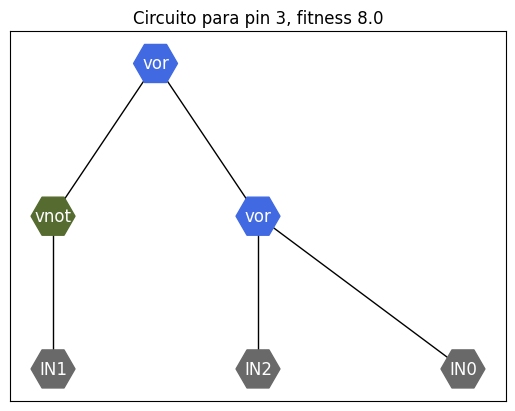

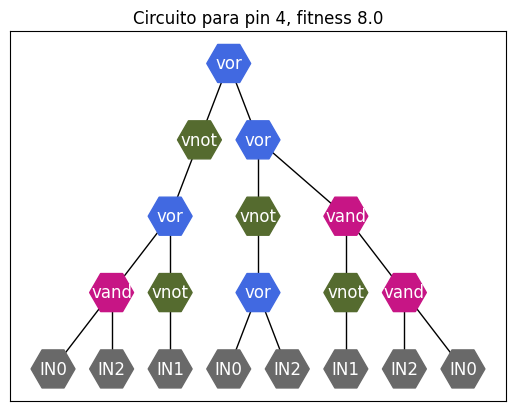

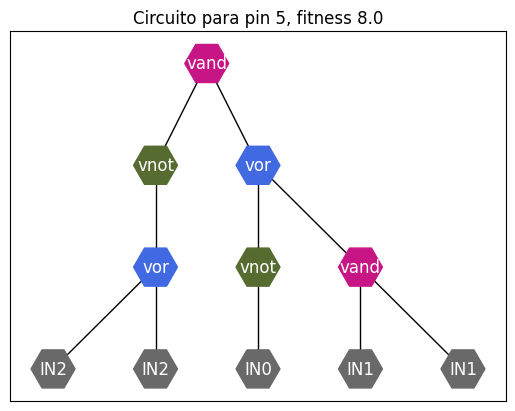

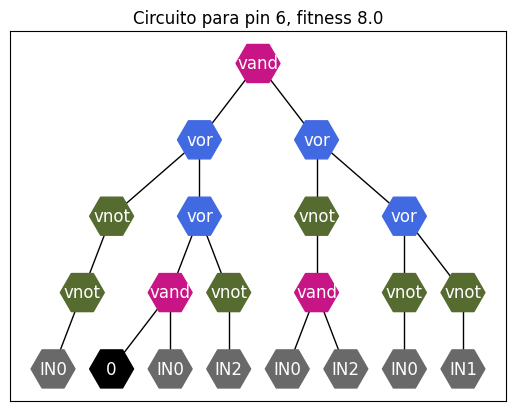

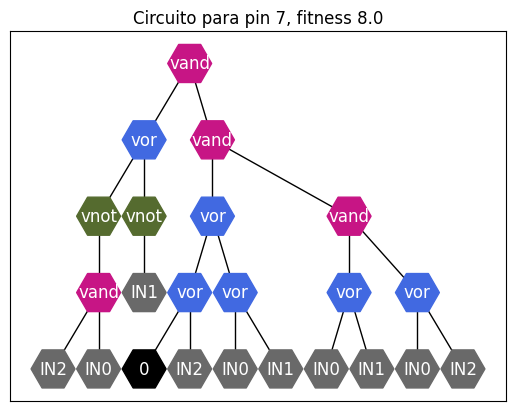

In [48]:
for i,r in enumerate(bests, start=1):
   graph(r,i)
_ = ""

# Conclusiones

Comprobamos que podemos generar circuitos por programación genética, aunque debido a limitaciones de la libreria utilizada, no podemos entrenar un individuo con multiples outputs, de ahi que cada circuito sea separado, es un buen primer aproximamiento. Entre las posibles mejoras para un trabajo futuro esta prevevnir las operaciones identidad y literales (como el or con 0 ó 1, ó el and con 0), además de buscar una codificación de los resultados para poder generar un único circuito 